# Learned drift detectors on CIFAR-10

Under the hood drift detectors leverage a function (also known as a test-statistic) that is expected to take a large value if drift has occurred and a low value if not. The power of the detector is partly determined by how well the function satisfies this property. However, specifying such a function in advance can be very difficult. In this example notebook we consider two ways in which a portion of the available data may be used to **learn** such a function before then applying it on the held out portion of the data to test for drift.

## Detecting drift with a learned classifier

The classifier-based drift detector simply tries to correctly distinguish instances from the reference data vs. the test set. The classifier is trained to output the probability that a given instance belongs to the test set. If the probabilities it assigns to unseen tests instances are significantly higher (as determined by a Kolmogorov-Smirnov test) to those it assigns to unseen reference instances then the test set must differ from the reference set and drift is flagged. To leverage all the available reference and test data, stratified cross-validation can be applied and the out-of-fold predictions are used for the significance test. Note that a new classifier is trained for each test set or even each fold within the test set.

### Backend

The method works with both the **PyTorch** and **TensorFlow** frameworks. Alibi Detect does however not install PyTorch for you. 
Check the [PyTorch docs](https://pytorch.org/) how to do this.

### Dataset

[CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) consists of 60,000 32 by 32 RGB images equally distributed over 10 classes. We evaluate the drift detector on the CIFAR-10-C dataset ([Hendrycks & Dietterich, 2019](https://arxiv.org/abs/1903.12261)). The instances in
CIFAR-10-C have been corrupted and perturbed by various types of noise, blur, brightness etc. at different levels of severity, leading to a gradual decline in the classification model performance. We also check for drift against the original test set with class imbalances. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from alibi_detect.cd import ClassifierDrift
from alibi_detect.utils.saving import save_detector, load_detector
from alibi_detect.datasets import fetch_cifar10c, corruption_types_cifar10c

### Load data

Original CIFAR-10 data:

In [2]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
y_train = y_train.astype('int64').reshape(-1,)
y_test = y_test.astype('int64').reshape(-1,)

For CIFAR-10-C, we can select from the following corruption types at 5 severity levels:

In [3]:
corruptions = corruption_types_cifar10c()
print(corruptions)

['brightness', 'contrast', 'defocus_blur', 'elastic_transform', 'fog', 'frost', 'gaussian_blur', 'gaussian_noise', 'glass_blur', 'impulse_noise', 'jpeg_compression', 'motion_blur', 'pixelate', 'saturate', 'shot_noise', 'snow', 'spatter', 'speckle_noise', 'zoom_blur']


Let's pick a subset of the corruptions at corruption level 5. Each corruption type consists of perturbations on all of the original test set images.

In [4]:
corruption = ['gaussian_noise', 'motion_blur', 'brightness', 'pixelate']
X_corr, y_corr = fetch_cifar10c(corruption=corruption, severity=5, return_X_y=True)
X_corr = X_corr.astype('float32') / 255

We split the original test set in a reference dataset and a dataset which should not be flagged as drift. We also split the corrupted data by corruption type:

In [5]:
np.random.seed(0)
n_test = X_test.shape[0]
idx = np.random.choice(n_test, size=n_test // 2, replace=False)
idx_h0 = np.delete(np.arange(n_test), idx, axis=0)
X_ref,y_ref = X_test[idx], y_test[idx]
X_h0, y_h0 = X_test[idx_h0], y_test[idx_h0]
print(X_ref.shape, X_h0.shape)

(5000, 32, 32, 3) (5000, 32, 32, 3)


In [6]:
n_corr = len(corruption)
X_c = [X_corr[i * n_test:(i + 1) * n_test] for i in range(n_corr)]

We can visualise the same instance for each corruption type:

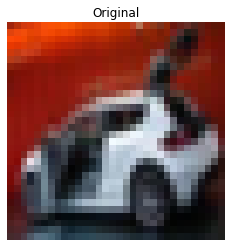

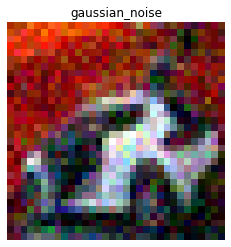

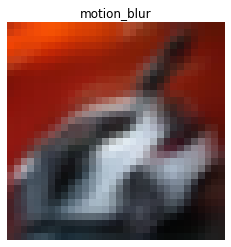

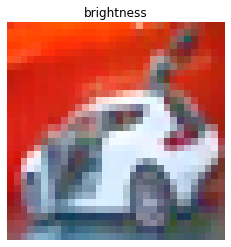

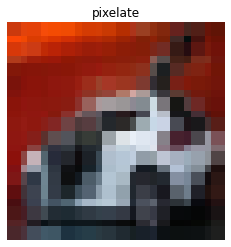

In [7]:
i = 6

n_test = X_test.shape[0]
plt.title('Original')
plt.axis('off')
plt.imshow(X_test[i])
plt.show()
for _ in range(len(corruption)):
    plt.title(corruption[_])
    plt.axis('off')
    plt.imshow(X_corr[n_test * _+ i])
    plt.show()

### Detect drift with a TensorFlow classifier

#### Single fold

We use a simple classification model and try to distinguish between the reference data and the corrupted test sets. The detector defaults to `binarize=False` which means a Kolmogorov-Smirnov test will be used to test for significant disparity between continuous model predictions (e.g. probabilities or logits). Initially we'll test at a significance level of $p=0.05$, use $75$% of the shuffled reference and test data for training and evaluate the detector on the remaining $25$%. We only train for 1 epoch.

In [8]:
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Input

tf.random.set_seed(0)

model = tf.keras.Sequential(
  [
      Input(shape=(32, 32, 3)),
      Conv2D(8, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(16, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(32, 4, strides=2, padding='same', activation=tf.nn.relu),
      Flatten(),
      Dense(2, activation='softmax')
  ]
)

cd = ClassifierDrift(X_ref, model, p_val=.05, train_size=.75, epochs=1)

Let's check whether the detector thinks drift occurred on the different test sets and time the prediction calls:

In [9]:
from timeit import default_timer as timer

labels = ['No!', 'Yes!']

def make_predictions(cd, x_h0, x_corr, corruption):
    t = timer()
    preds = cd.predict(x_h0)
    dt = timer() - t
    print('No corruption')
    print('Drift? {}'.format(labels[preds['data']['is_drift']]))
    print(f'p-value: {preds["data"]["p_val"]:.3f}')
    print(f'Time (s) {dt:.3f}')
    
    if isinstance(x_corr, list):
        for x, c in zip(x_corr, corruption):
            t = timer()
            preds = cd.predict(x)
            dt = timer() - t
            print('')
            print(f'Corruption type: {c}')
            print('Drift? {}'.format(labels[preds['data']['is_drift']]))
            print(f'p-value: {preds["data"]["p_val"]:.3f}')
            print(f'Time (s) {dt:.3f}')

In [10]:
make_predictions(cd, X_h0, X_c, corruption)

No corruption
Drift? No!
p-value: 0.685
Time (s) 2.752

Corruption type: gaussian_noise
Drift? Yes!
p-value: 0.000
Time (s) 3.154

Corruption type: motion_blur
Drift? Yes!
p-value: 0.000
Time (s) 3.263

Corruption type: brightness
Drift? Yes!
p-value: 0.000
Time (s) 3.240

Corruption type: pixelate
Drift? Yes!
p-value: 0.000
Time (s) 3.160


As expected, drift was only detected on the corrupted datasets and the classifier could easily distinguish the corrupted from the reference data.

#### Use all the available data via cross-validation

So far we've only used $25$% of the data to detect the drift since $75$% is used for training purposes. At the cost of additional training time we can however leverage all the data via stratified cross-validation. We just need to set the number of folds and keep everything else the same. So for each test set `n_folds` models are trained, and the out-of-fold predictions combined for the significance test:

In [11]:
cd = ClassifierDrift(X_ref, model, p_val=.05, n_folds=5, epochs=1)

Both `n_folds` and `train_size` specified. By default `n_folds` is used.


In [12]:
make_predictions(cd, X_h0, X_c, corruption)

No corruption
Drift? No!
p-value: 0.738
Time (s) 11.437

Corruption type: gaussian_noise
Drift? Yes!
p-value: 0.000
Time (s) 16.781

Corruption type: motion_blur
Drift? Yes!
p-value: 0.000
Time (s) 19.431

Corruption type: brightness
Drift? Yes!
p-value: 0.000
Time (s) 17.396

Corruption type: pixelate
Drift? Yes!
p-value: 0.000
Time (s) 16.747


## Detecting drift with a learned kernel

An alternative to training a classifier to output high probabilities for instances from the test window and low probabilities for instances from the reference window is to learn a kernel that outputs high similarities between instances from the same window and low similarities between instances from different windows. The kernel may then be used within an [MMD-test](https://docs.seldon.io/projects/alibi-detect/en/latest/examples/cd_mmd_cifar10.html) for drift. [Liu et al. (2020)](https://arxiv.org/abs/2002.09116) propose this learned approach and note that it is in fact a generalisation of the above classifier-based method. However, in this case we can train the kernel to directly optimise an estimate of the detector's power, which can result in superior performance.

### Detect drift with a learned PyTorch kernel

Any differentiable *Pytorch* or *TensorFlow* module that takes as input two instances and outputs a scalar (representing similarity) can be used as the kernel for this drift detector. However, in order to ensure that MMD=0 implies no-drift the kernel should satify a *characteristic* property. This can be guarenteed by defining a kernel as $$k(x,y)=(1-\epsilon)*k_a(\Phi(x), \Phi(y)) + \epsilon*k_b(x,y),$$ where $\Phi$ is a learnable projection, $k_a$ and $k_b$ are simple characteristic kernels (such as a [Gaussian RBF](https://en.wikipedia.org/wiki/Radial_basis_function_kernel), and $\epsilon>0$ is a small constant. By letting $\Phi$ be very flexible we can learn powerful kernels in this manner.

This can be implemented as shown below. We use *Pytorch* instead of *TensorFlow* this time for the sake of variety. Because we are dealing with images we give our projection $\Phi$ a convolutional architecture.

In [13]:
import torch
import torch.nn as nn

# set random seed and device
seed = 0
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# define the projection
proj = nn.Sequential(
    nn.Conv2d(3, 8, 4, stride=2, padding=0),
    nn.ReLU(),
    nn.Conv2d(8, 16, 4, stride=2, padding=0),
    nn.ReLU(),
    nn.Conv2d(16, 32, 4, stride=2, padding=0),
    nn.ReLU(),
    nn.Flatten(),
).to(device)

We may then specify a `DeepKernel` in the following manner. By default `GaussianRBF` kernels are used for $k_a$ and $k_b$ and here we specify $\epsilon=0.01$, but we could alternatively set `eps='trainable'`.

In [14]:
from alibi_detect.utils.pytorch.kernels import DeepKernel
kernel = DeepKernel(proj, eps=0.01)

Since our *PyTorch* encoder expects the images in a *(batch size, channels, height, width)* format, we transpose the data. Note that this step could also be passed to the drift detector via the `preprocess_fn` kwarg:

In [15]:
def permute_c(x):
    return np.transpose(x.astype(np.float32), (0, 3, 1, 2))

X_ref_pt = permute_c(X_ref)
X_h0_pt = permute_c(X_h0)
X_c_pt = [permute_c(xc) for xc in X_c]
print(X_ref_pt.shape, X_h0_pt.shape, X_c_pt[0].shape)

(5000, 3, 32, 32) (5000, 3, 32, 32) (10000, 3, 32, 32)


We then pass the kernel to the `LearnedKernelDrift` detector. By default $75\%$ of the data is used to train the kernel and the MMD-test is performed on the other $25\%$.

In [16]:
from alibi_detect.cd import LearnedKernelDrift
cd = LearnedKernelDrift(X_ref_pt, kernel, backend='pytorch', p_val=.05, epochs=1)

No GPU detected, fall back on CPU.


In [17]:
make_predictions(cd, X_h0_pt, X_c_pt, corruption)

No corruption
Drift? No!
p-value: 0.890
Time (s) 9.776

Corruption type: gaussian_noise
Drift? Yes!
p-value: 0.000
Time (s) 21.204

Corruption type: motion_blur
Drift? Yes!
p-value: 0.000
Time (s) 21.514

Corruption type: brightness
Drift? Yes!
p-value: 0.000
Time (s) 24.910

Corruption type: pixelate
Drift? Yes!
p-value: 0.040
Time (s) 25.152
